In [1]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset -p /content/mango_leaf_disease --unzip

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 102M/103M [00:05<00:00, 24.0MB/s] 
100% 103M/103M [00:05<00:00, 19.0MB/s]


In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [3]:
base_dir = '/content/mango_leaf_disease'

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [5]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [6]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 134s 949ms/step - accuracy: 0.2616 - loss: 2.0644 - val_accuracy: 0.6125 - val_loss: 1.7814 - learning_rate: 1.0000e-05
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 890ms/step - accuracy: 0.6594 - loss: 1.0019 - val_accuracy: 0.7525 - val_loss: 1.4353 - learning_rate: 1.0000e-05
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 895ms/step - accuracy: 0.7753 - loss: 0.6781 - val_accuracy: 0.7975 - val_loss: 1.0132 - learning_rate: 1.0000e-05
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 898ms/step - accuracy: 0.8564 - loss: 0.4681 - val_accuracy: 0.8512 - val_loss: 0.6590 - learning_rate: 1.0000e-05
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 95s 908ms/step - accuracy: 0.8736 - loss: 0.4048 - val_accuracy: 0.8763 - val_loss: 0.4713 - learning_rate: 1.0000e-05
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 916ms/step - accuracy: 0.8954 - loss: 0.3355 - val_accuracy: 0.9013 - val_loss: 0.3664 - learning_rate: 1.0000e-05
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 899ms/st

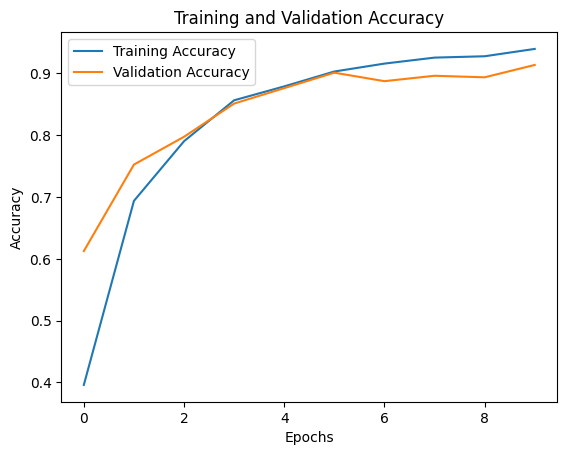

In [7]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='upper left')
plt.show()